Objectives:
- look at size fractionated chl data

In [1]:
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey
from sqlalchemy.orm import mapper, create_session, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
from sqlalchemy.sql import select, and_, or_, not_, func
from time import strptime
import csv
import re
import os
import glob
import numpy as np
import string
import pandas as pd
import seawater as sw # for sw.dpth(p,lat) 
import warnings
import datetime as dt
from mpl_toolkits.basemap import Basemap #, shiftgrid, cm
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from scipy import stats as spst
from mpl_toolkits.basemap import Basemap, shiftgrid, cm

%matplotlib inline

# load database and tables

In [2]:
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'STRATOGEM/'
dbname='STRATOGEM'

In [3]:
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

In [4]:
print([i for i in Base.classes])

[<class 'sqlalchemy.ext.automap.CTDProfTBL'>, <class 'sqlalchemy.ext.automap.CombStationTBL'>, <class 'sqlalchemy.ext.automap.ChlStationTBL'>, <class 'sqlalchemy.ext.automap.CombProfTBL'>, <class 'sqlalchemy.ext.automap.ChlProfTBL'>, <class 'sqlalchemy.ext.automap.CTDStationTBL'>]


In [5]:
ChlStaTBL=Base.classes.ChlStationTBL
ChlProfTBL=Base.classes.ChlProfTBL
CombStaTBL=Base.classes.CombStationTBL
CombProfTBL=Base.classes.CombProfTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [6]:
findData=session.query(ChlStaTBL.ID,ChlStaTBL.Lat,ChlStaTBL.Lon,ChlStaTBL.Year,ChlStaTBL.Mon,ChlStaTBL.Day,
                       ChlStaTBL.StName,ChlProfTBL.depth,ChlProfTBL.chl002,ChlProfTBL.chl020,
                       ChlProfTBL.chl200).select_from(ChlProfTBL).join(ChlStaTBL,ChlStaTBL.ID==ChlProfTBL.ChlStationTBLID).\
                 filter(and_(
                        ChlProfTBL.depth>0,
                        or_(ChlProfTBL.chl002>=0,
                            ChlProfTBL.chl020>=0,
                            ChlProfTBL.chl200>=0)
                )).order_by(ChlProfTBL.ChlStationTBLID,ChlProfTBL.depth)
fdsub=findData.subquery()

In [7]:
test1=session.query(fdsub.c.ID,fdsub.c.StName,fdsub.c.depth,func.count(fdsub.c.chl002).label('N')).\
                group_by(fdsub.c.ID,fdsub.c.depth)
df=pd.DataFrame(test1.all())
np.max(df['N'])

1

In [8]:
test=session.query(fdsub.c.StName,fdsub.c.Lat,fdsub.c.Lon).group_by(fdsub.c.StName).order_by(fdsub.c.Lat)
dflocs=pd.DataFrame(test.all())
for row in test.all():
    print(row)

('S1', 48.91615, -123.25391666666667)
('S2-1', 48.980066666666666, -123.48815)
('S2-2', 49.02543333333333, -123.42501666666666)
('S2-3', 49.0816, -123.35186666666667)
('P2', 49.09141666666667, -123.44861666666667)
('T2', 49.09251666666667, -123.45048333333334)
('P3', 49.116166666666665, -123.49853333333333)
('S3', 49.12518333333333, -123.55843333333334)
('T3', 49.13186666666667, -123.53553333333333)
('P5', 49.16141666666667, -123.57498333333334)
('T4', 49.1795, -123.60345)
('P7', 49.19931666666667, -123.64095)
('P8', 49.21516666666667, -123.67286666666666)
('T5', 49.21563333333334, -123.67121666666667)
('S4-2', 49.2342, -123.58411666666666)
('S4-3', 49.25006666666667, -123.3834)
('S4-1', 49.25035, -123.74993333333333)
('T7', 49.30383333333333, -123.79861666666666)
('S5', 49.3576, -123.8496)
('S6-1', 49.381483333333335, -124.18253333333334)
('S6-2', 49.46326666666667, -124.04516666666666)
('S7-1', 49.561766666666664, -124.57551666666667)
('S7-2', 49.59705, -123.46701666666667)
('S7-3', 

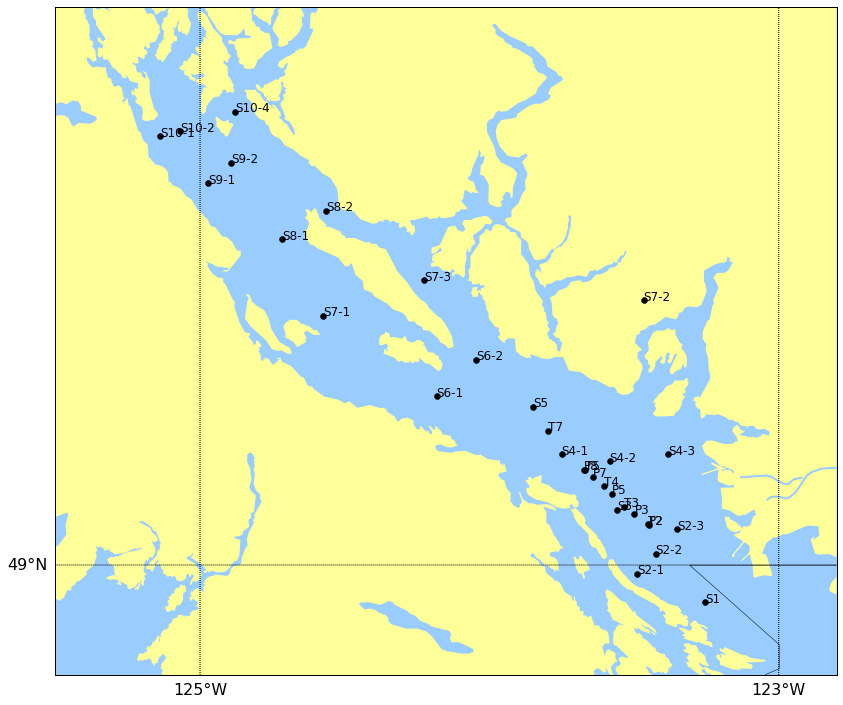

In [9]:
fig=plt.figure(figsize=(14,14))
lonmin=-125.5
lonmax=-122.8
latmin=48.75
latmax=50.25
m = Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,\
            llcrnrlon=lonmin,urcrnrlon=lonmax,resolution='h')
# fill background.
m.drawmapboundary(fill_color=(.6,.8,1))
m.fillcontinents(color=(1,1,.6),lake_color=(.6,.8,1))
# draw coasts and fill continents.
#m.drawcoastlines(linewidth=0.5)
m.drawrivers(color=(.6,.8,1),linewidth=2)
#m.shadedrelief()
# 20 degree graticule.
m.drawparallels(np.arange(int(latmin)+1,int(latmax)+1,2),labels=[1,0,0,1],size=16)
m.drawmeridians(np.arange(int(lonmin),int(lonmax)+1,2),labels=[1,0,0,1],size=16)
m.drawcountries()
m.drawstates()
for st in dflocs['StName']:#['S1','S3','S4-1','S9-1']:
    lon,lat=dflocs.loc[dflocs['StName']==st,['Lon','Lat']].values[0]
    m.plot(lon,lat,'ko',latlon=True)
    x,y = m(lon, lat)
    plt.text(x,y,st,size=12)
    

(0, 40)

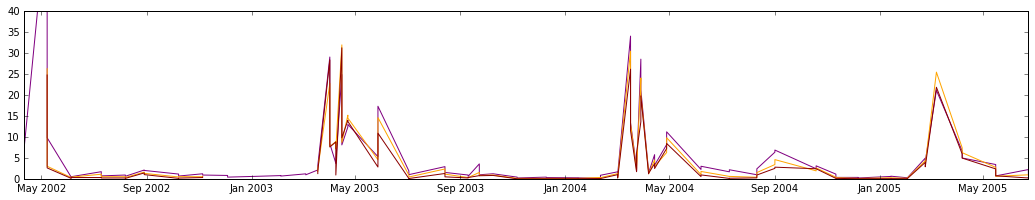

In [10]:
qS3=session.query(ChlStaTBL.ID,ChlStaTBL.Lat,ChlStaTBL.Lon,ChlStaTBL.Year,ChlStaTBL.Mon,ChlStaTBL.Day,
                       ChlStaTBL.StName,ChlProfTBL.depth,ChlProfTBL.chl002,ChlProfTBL.chl020,
                       ChlProfTBL.chl200).select_from(ChlProfTBL).join(ChlStaTBL,ChlStaTBL.ID==ChlProfTBL.ChlStationTBLID).\
                 filter(and_(
                        ChlStaTBL.StName=='S3',
                        ChlProfTBL.depth>0,
                        or_(ChlProfTBL.chl002>=0,
                            ChlProfTBL.chl020>=0,
                            ChlProfTBL.chl200>=0)
                )).order_by(ChlStaTBL.Year,ChlStaTBL.Mon,ChlStaTBL.Day,ChlProfTBL.depth)
dfS3=pd.DataFrame(qS3.all())
dfS3['DT']=[dt.datetime(r.Year,r.Mon,r.Day) for i,r in dfS3.iterrows()]
dfS3['YD']=[(dt.datetime(r.Year,r.Mon,r.Day)-dt.datetime(r.Year-1,12,31)).days for i,r in dfS3.iterrows()]

fig,ax=plt.subplots(1,1,figsize=(18,3))
ax.plot(dfS3['DT'],dfS3['chl002'],'-',color='purple')
ax.plot(dfS3['DT'],dfS3['chl020'],'-',color='orange')
ax.plot(dfS3['DT'],dfS3['chl200'],'-',color='darkred')
ax.set_ylim([0,40])

Means: StName, large, small, smallest
S1 3.24690123457 0.475320987654 0.205259259259
S2-1 3.20744303797 0.648556962025 0.429911392405
S2-2 4.09511956522 0.807597826087 0.378130434783
S2-3 3.80289411765 0.517635294118 0.419372093023
P2 0.7975 0.305 0.54
T2 0.30525 1.3205 0.526375
P3 0.282 0.3185 0.918
S3 3.87921176471 0.590223529412 0.904011764706
T3 0.338375 1.66525 0.96525
P5 1.197 0.452 1.513
T4 1.063875 1.898875 1.055875
P7 1.1025 0.333 0.9085
P8 1.4115 0.4785 0.854
T5 0.621125 1.855875 0.9325
S4-2 3.65668235294 0.739364705882 0.826682352941
S4-3 3.8925 0.508976190476 1.4509047619
S4-1 3.9409787234 0.72870212766 0.685765957447
T7 0.4475 1.181 0.582125
S5 3.80054444444 0.593888888889 0.839516483516
S6-1 0.0435 0.3665 1.08
S6-2 0.649 0.993 1.0835


/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly 

S7-1 0.046 0.339 1.414
S7-2 0.1055 1.167 2.862
S7-3 0.59 0.2055 1.06
S8-1 0.3435 0.485 1.652
S8-2 0.155 0.204 1.4675


/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly 

S9-1 0.0945 0.3935 1.661
S9-2 0.248 0.4785 1.7995
S10-1 0.66 0.268 0.662
S10-2 1.268 0.749 1.236
S10-4 0.5795 0.7895 1.4385


/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly 

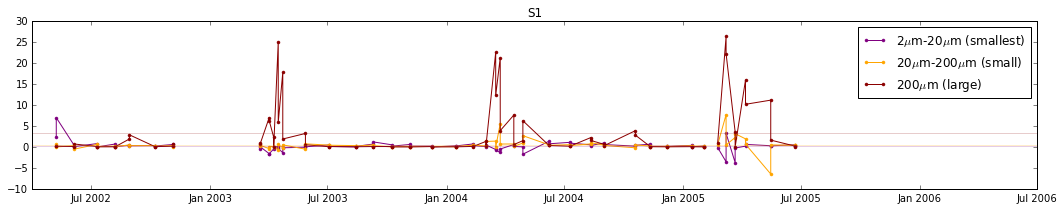

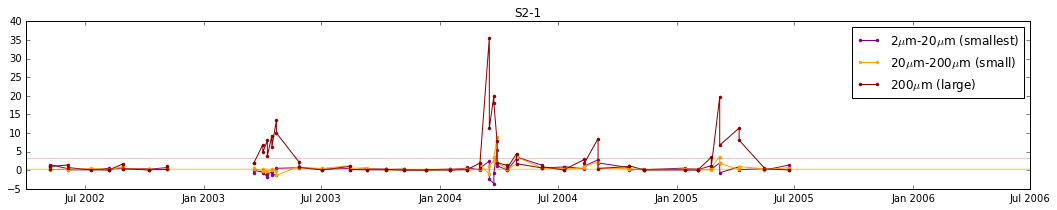

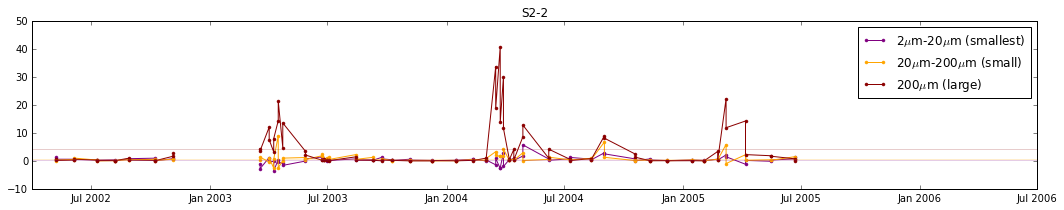

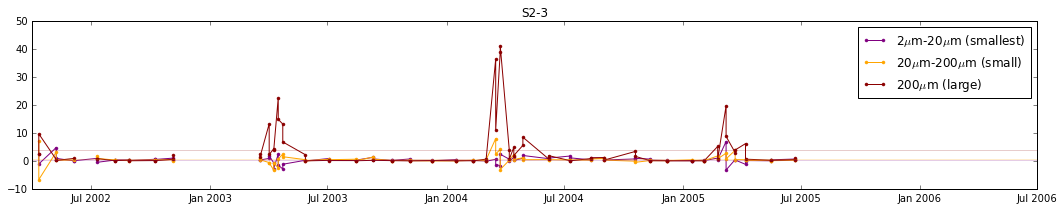

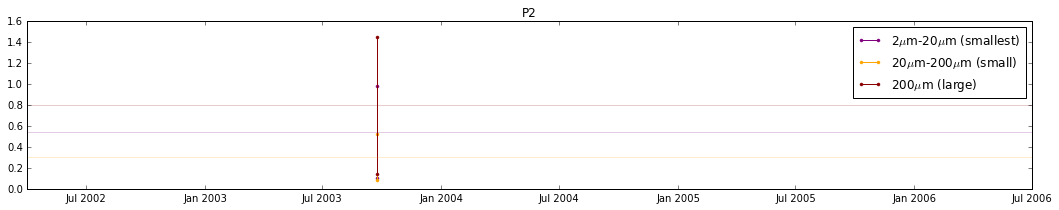

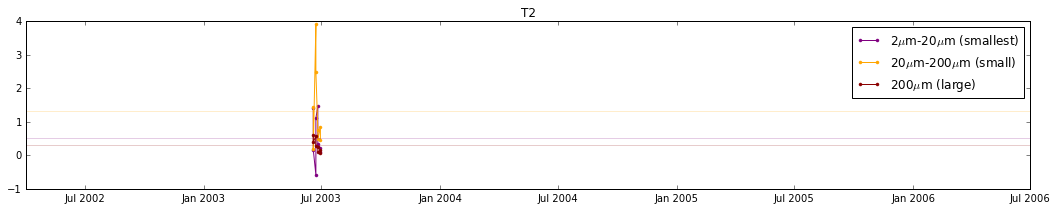

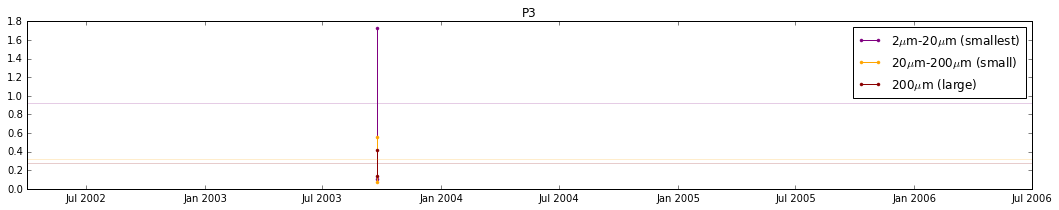

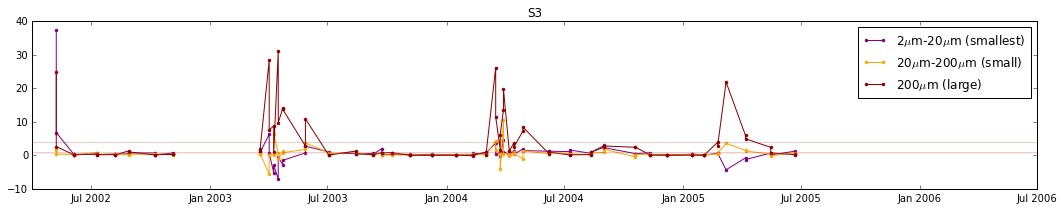

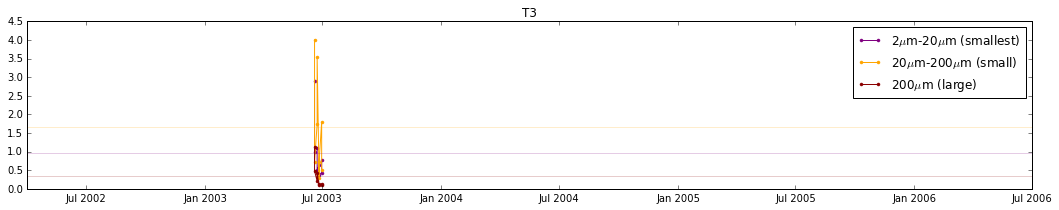

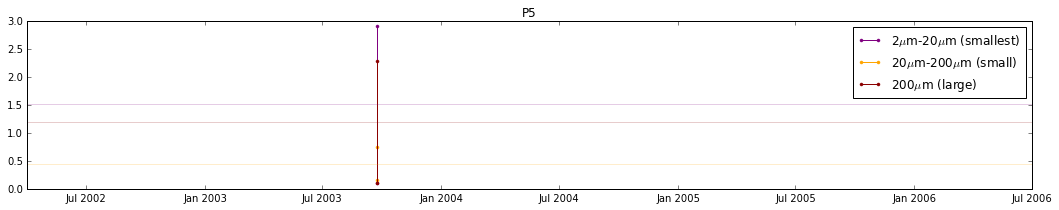

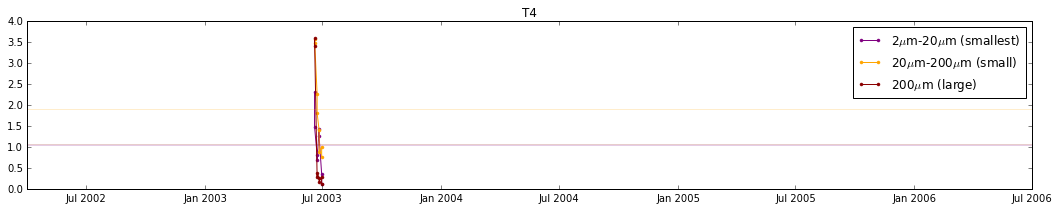

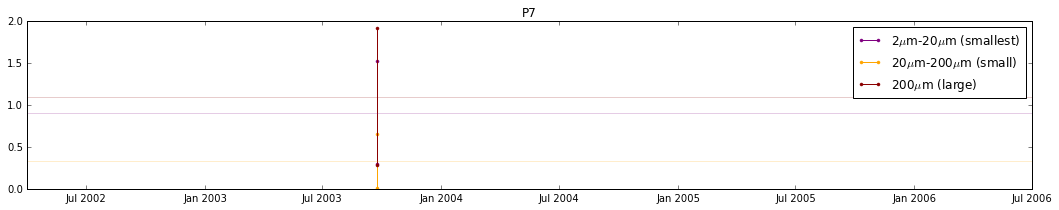

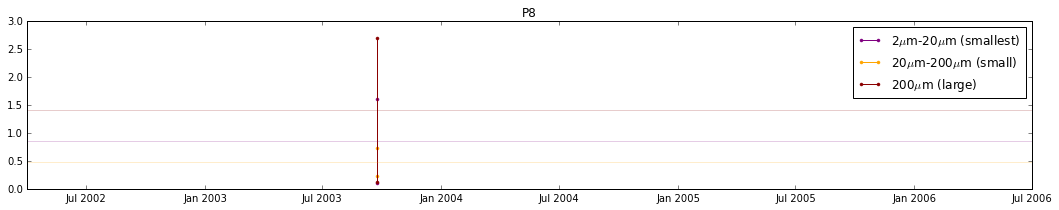

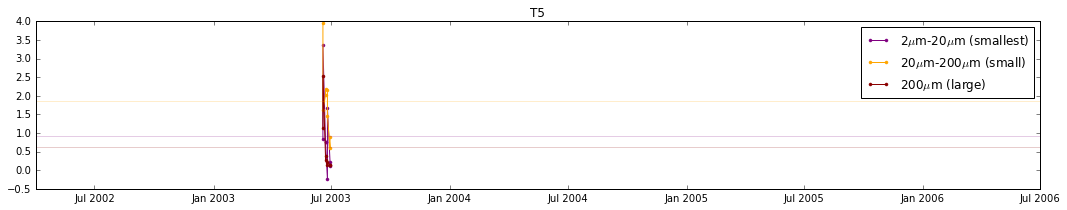

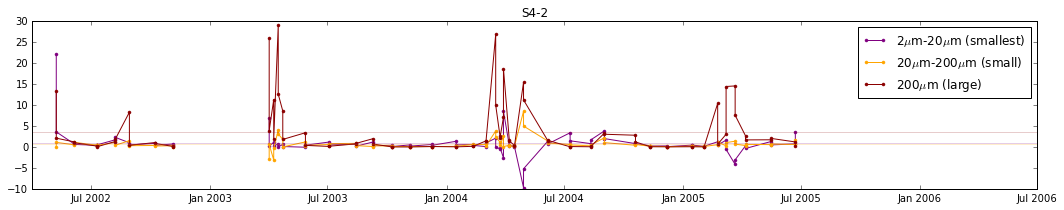

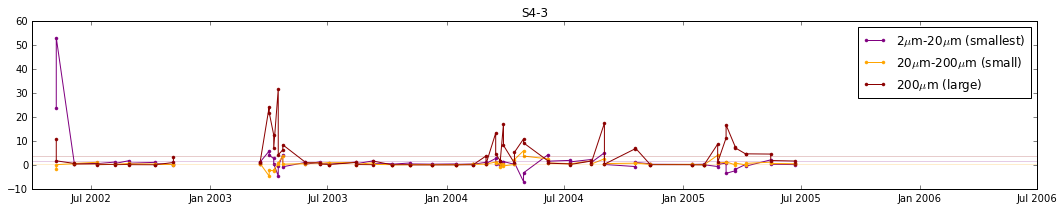

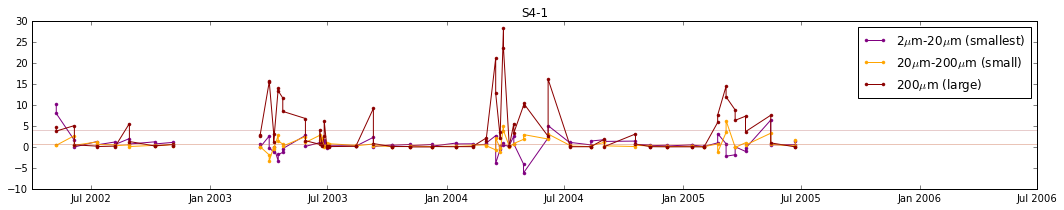

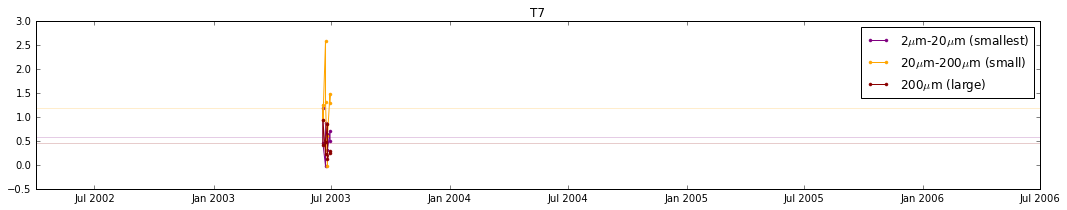

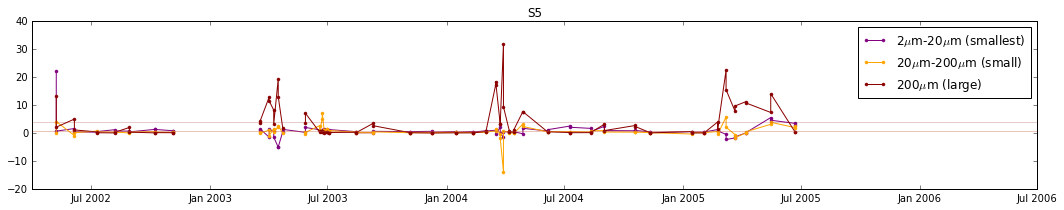

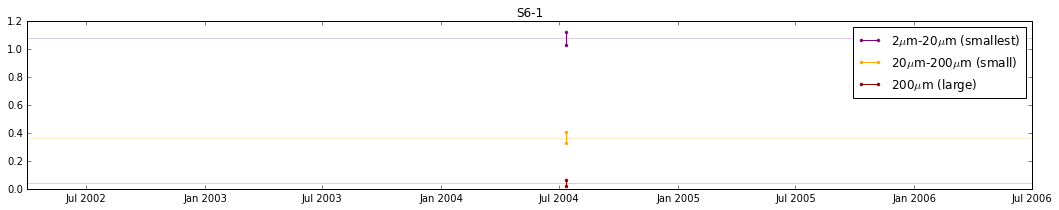

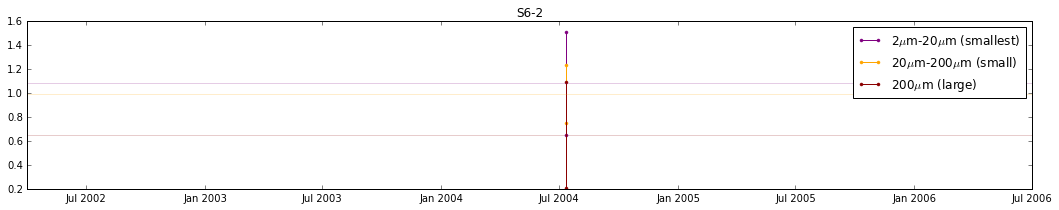

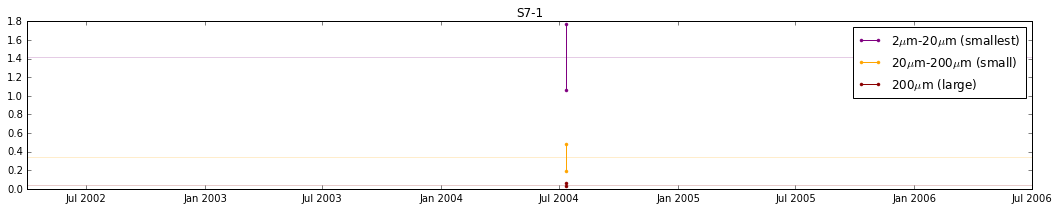

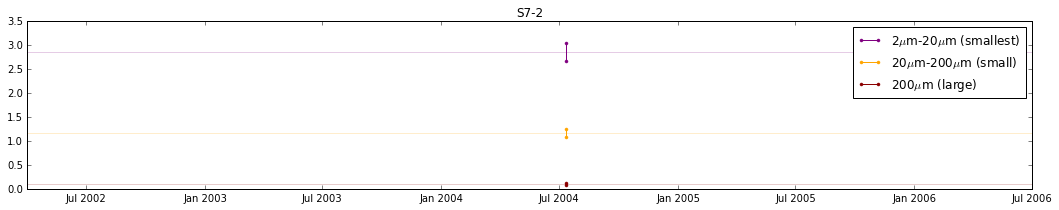

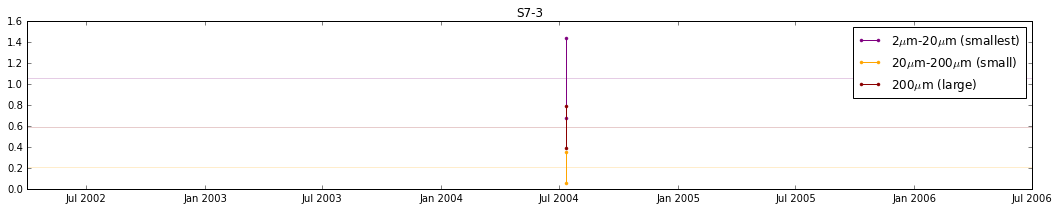

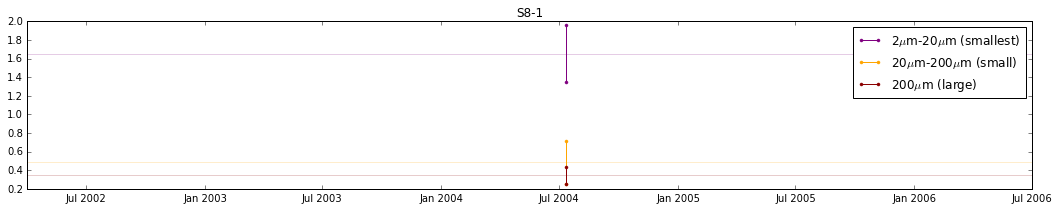

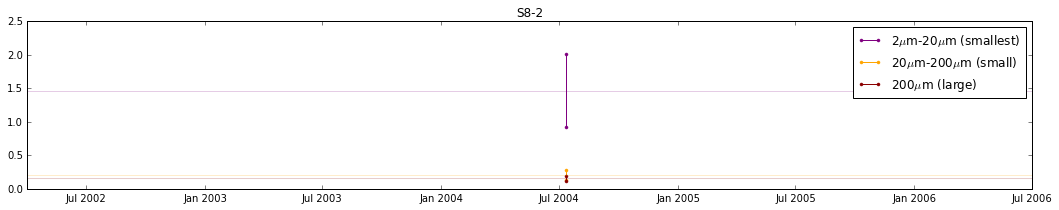

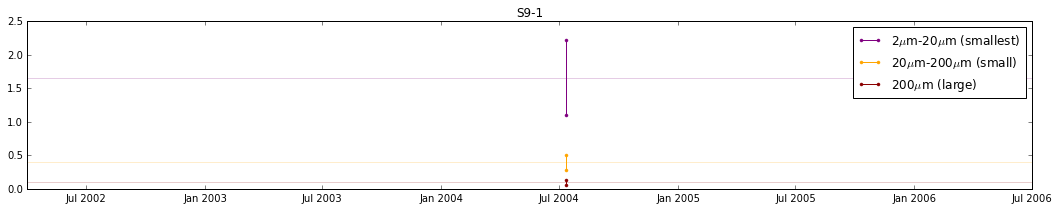

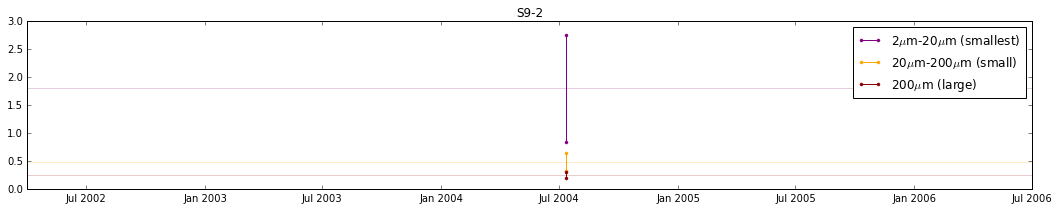

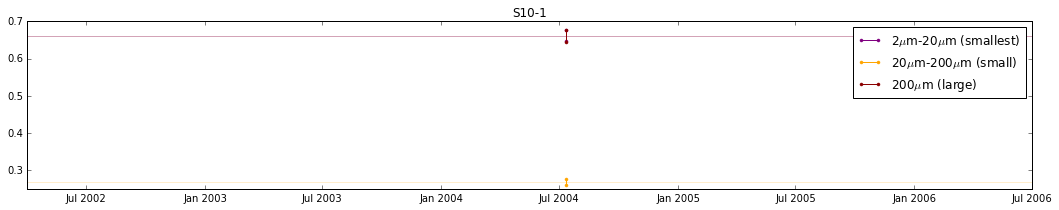

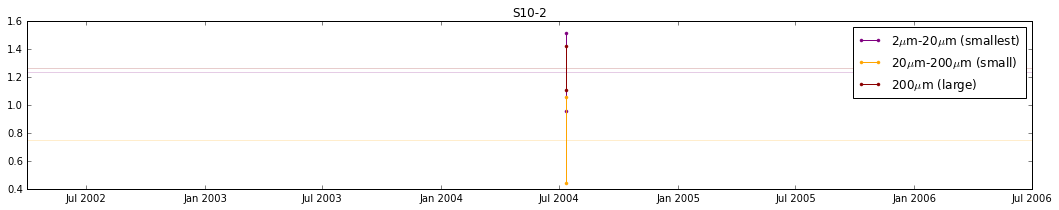

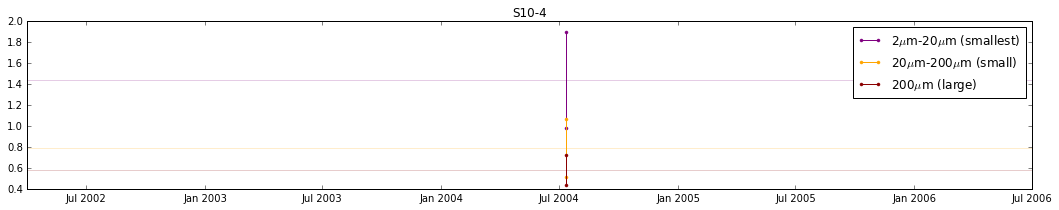

In [11]:
print('Means: StName, large, small, smallest')
for st in dflocs['StName']:#['S1','S3','S4-1','S9-1','S9-2']:
    qS3=session.query(ChlStaTBL.ID,ChlStaTBL.Lat,ChlStaTBL.Lon,ChlStaTBL.Year,ChlStaTBL.Mon,ChlStaTBL.Day,
                           ChlStaTBL.StName,ChlProfTBL.depth,ChlProfTBL.chl002,ChlProfTBL.chl020,
                           ChlProfTBL.chl200).select_from(ChlProfTBL).join(ChlStaTBL,ChlStaTBL.ID==ChlProfTBL.ChlStationTBLID).\
                     filter(and_(
                            ChlStaTBL.StName==st,
                            ChlProfTBL.depth>0,
                            or_(ChlProfTBL.chl002>=0,
                                ChlProfTBL.chl020>=0,
                                ChlProfTBL.chl200>=0)
                    )).order_by(ChlStaTBL.Year,ChlStaTBL.Mon,ChlStaTBL.Day,ChlProfTBL.depth)
    dfS3=pd.DataFrame(qS3.all())
    dfS3['DT']=[dt.datetime(r.Year,r.Mon,r.Day) for i,r in dfS3.iterrows()]
    dfS3['YD']=[(dt.datetime(r.Year,r.Mon,r.Day)-dt.datetime(r.Year-1,12,31)).days for i,r in dfS3.iterrows()]

    fig,ax=plt.subplots(1,1,figsize=(18,3))
    ax.plot(dfS3['DT'],dfS3['chl002']-dfS3['chl020'],'.-',color='purple',label='2$\mu$m-20$\mu$m (smallest)')
    ax.plot(dfS3['DT'],dfS3['chl020']-dfS3['chl200'],'.-',color='orange',label='20$\mu$m-200$\mu$m (small)')
    ax.plot(dfS3['DT'],dfS3['chl200'],'.-',color='darkred',label='200$\mu$m (large)')
    #ax.set_ylim([0,40])
    ax.set_title(st)
    ax.legend()
    print(st,np.nanmean(dfS3['chl200']),np.nanmean(dfS3['chl020']-dfS3['chl200']),np.nanmean(dfS3['chl002']-dfS3['chl020']))
    ax.plot((dt.datetime(2002,4,1),dt.datetime(2006,7,1)),np.mean(dfS3['chl002']-dfS3['chl020'])*np.ones((2,)),'-',color='purple',alpha=.2)
    ax.plot((dt.datetime(2002,4,1),dt.datetime(2006,7,1)),np.mean(dfS3['chl020']-dfS3['chl200'])*np.ones((2,)),'-',color='orange',alpha=.2)
    ax.plot((dt.datetime(2002,4,1),dt.datetime(2006,7,1)),np.mean(dfS3['chl200'])*np.ones((2,)),'-',color='darkred',alpha=.2)
    